In [40]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate
sns.set_style("darkgrid")

In [41]:
def readFile(file_path, rows=100000):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    f = open(file_path, "r")
    count = 0
    for line in f:
        count += 1
        if count > rows:
            break
            
        if ':' in line:
            movidId = line[:-2] # remove the last character ':'
            movieId = int(movidId)
        else:
            customerID, rating, date = line.split(',')
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    f.close()
            
    return pd.DataFrame(data_dict)

In [42]:
df1 = readFile('D:\\Netflix_recomm\\data\\combined_data_1.txt', rows=100000)
df2 = readFile('D:\\Netflix_recomm\\data\\combined_data_2.txt', rows=100000)
df3 = readFile('D:\\Netflix_recomm\\data\\combined_data_3.txt', rows=100000)
df4 = readFile('D:\\Netflix_recomm\\data\\combined_data_4.txt', rows=100000)

In [43]:
df1.head()

,Cust_Id,Movie_Id,Rating,Date
0,1488844,1,3,2005-09-06
1,822109,1,5,2005-05-13
2,885013,1,4,2005-10-19
3,30878,1,4,2005-12-26
4,823519,1,3,2004-05-03


In [5]:
#df2.head()
#df3.head()
#df4.head()


In [44]:
df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)



df = df1.copy()
df = df.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
df.shape

(399899, 4)

In [45]:
df.head(10)

,Cust_Id,Movie_Id,Rating,Date
0,1488844,1,3.0,2005-09-06
1,822109,1,5.0,2005-05-13
2,885013,1,4.0,2005-10-19
3,30878,1,4.0,2005-12-26
4,823519,1,3.0,2004-05-03
5,893988,1,3.0,2005-11-17
6,124105,1,4.0,2004-08-05
7,1248029,1,3.0,2004-04-22
8,1842128,1,4.0,2004-05-09
9,2238063,1,3.0,2005-05-11


**DATA VIEWING**

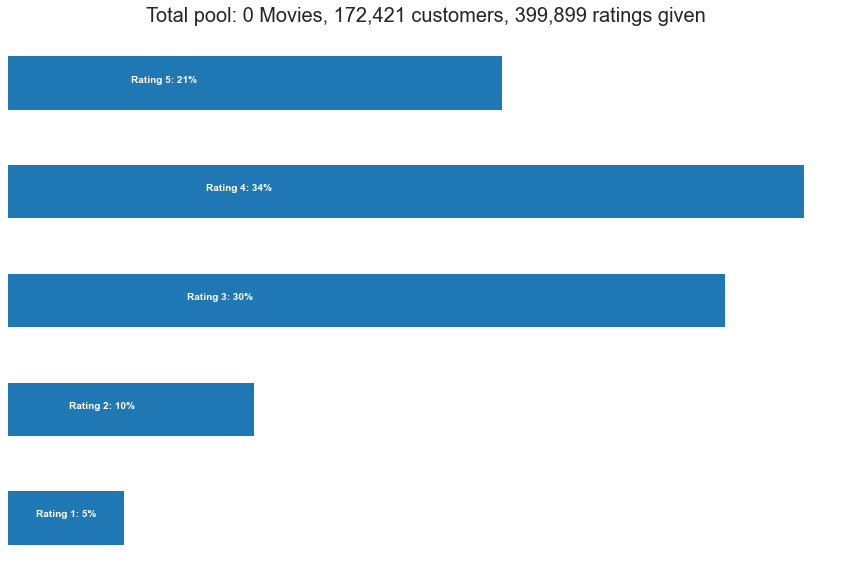

In [46]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [47]:
df['Movie_Id'].value_counts()

28       39752
13384    37884
4506     33731
4520     26500
9235     20214
         ...  
9221       105
4502       104
9           95
7           93
9227        88
Name: Movie_Id, Length: 101, dtype: int64

**DATA SLICING**

reduce the data volumn by improving the data quality below:

       -Remove movie with too less reviews (they are relatively not popular)
       -Remove customer who give too less reviews (they are relatively less active)

In [48]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 2516.0
Customer minimum times of review: 2.0


In [49]:
#trimming the data
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (399899, 4)
After Trim Shape: (356621, 4)
-Data Examples-
     Cust_Id  Movie_Id  Rating        Date
5098  824097         8     2.0  2005-07-08


In [77]:
#pivoting data set into matrix for recommender model
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)


(163030, 31)


In [78]:
#loading into movie mapping file
df_title = pd.read_csv('D:\\Netflix_recomm\\data\\movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.head(10)

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
6,7,1992.0,8 Man
7,8,2004.0,What the #$*! Do We Know!?
8,9,1991.0,Class of Nuke 'Em High 2
9,10,2001.0,Fighter


**RECOMMENDER MODELS**

1. Collaborative filtering

In [52]:
reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
svd = SVD()
# Run 5-fold cross-validation and print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0157  1.0189  1.0169  1.0114  1.0150  1.0156  0.0025  
MAE (testset)     0.8104  0.8115  0.8101  0.8074  0.8091  0.8097  0.0014  
Fit time          45.93   45.92   46.07   46.99   48.32   46.65   0.93    
Test time         1.42    1.87    1.76    1.50    1.76    1.66    0.17    


{'test_rmse': array([1.01571884, 1.01886991, 1.01687597, 1.01140641, 1.01500046]),
 'test_mae': array([0.81040314, 0.81152795, 0.8101039 , 0.80743088, 0.80905432]),
 'fit_time': (45.92670440673828,
  45.92365527153015,
  46.067967891693115,
  46.99372386932373,
  48.32181358337402),
 'test_time': (1.4218268394470215,
  1.873018741607666,
  1.75956130027771,
  1.4989490509033203,
  1.756840705871582)}

In [58]:
#analyzing past record for random user 785314
df_785314 = df[(df['Cust_Id'] == '785314') & (df['Rating'] >= 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
df_785314.head(df_785314.shape[0])


Movie_Id
13378    Kim Possible: A Sitch in Time
Name: Name, dtype: object

In [54]:
# getting full dataset
# data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

In [59]:
#predicting which movies user 785420 would love to watch:
titles = df_title.copy()

titles['Estimate_Score'] = titles['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)
titles = titles.sort_values(by=['Estimate_Score'], ascending=False)

In [69]:
#user 785314's top 10 recommendations
titles.head(10)

,Movie_Id,Year,Name,Estimate_Score
4505,4506,1961.0,Breakfast at Tiffany's,4.026513
4508,4509,1977.0,Little House on the Prairie: Season 4,3.991144
13377,13378,1940.0,His Girl Friday,3.901095
13383,13384,1979.0,Kramer vs. Kramer,3.892904
27,28,2002.0,Lilo and Stitch,3.858321
13369,13370,2002.0,Justice League: Paradise Lost,3.856896
4507,4508,1966.0,Star Trek: The Original Series: Vols. 1-15,3.856162
13382,13383,2000.0,If These Walls Could Talk 2,3.834861
4521,4522,1998.0,Independent's Day,3.768126
17,18,1994.0,Immortal Beloved,3.748589


2. Pearsons' R correlation

we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [83]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons' R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend('His Girl Friday', 0)